In [387]:
!pip install -qU xgboost
!pip install -qU lightgbm

In [388]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import norm, skew
import os

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import RobustScaler

plt.style.use("fivethirtyeight")
pd.pandas.set_option('display.max_columns', None)
sns.set_style('darkgrid')
%matplotlib inline

In [389]:
# read datasets

train = pd.read_csv('D:\\House Price Regresion\\train.csv')
test = pd.read_csv('D:\\\House Price Regresion\\test.csv')

In [390]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [391]:
test['Id'].values

array([1461, 1462, 1463, ..., 2917, 2918, 2919])

In [392]:
# dropping ID

train.drop(['Id'], axis=1, inplace=True)

test_id = test['Id'].values # for submission
test.drop(['Id'], axis=1, inplace=True)

# Combining train and test to apply transformations.


# Feature Engineering

Feature engineering is the process of using domain knowledge of the data to transform existing features or to create new variables from existing ones, for use in machine learning.

[feature engineering](https://www.trainindata.com/post/feature-engineering-comprehensive-overview)

In this notebook we'll build on the insights we gattered from the first kernel.
We'll dive into:
1. Outlier Engineering
1. Missing Data Imputation
2. Variable Transformation
3. Date and Time Engineering
4. Categorical Encoding
5. Feature Creation (if necessary)

# Outlier removal

There are two outliers present as seen previously in the plot of `GrlivArea` and `SalePrice`

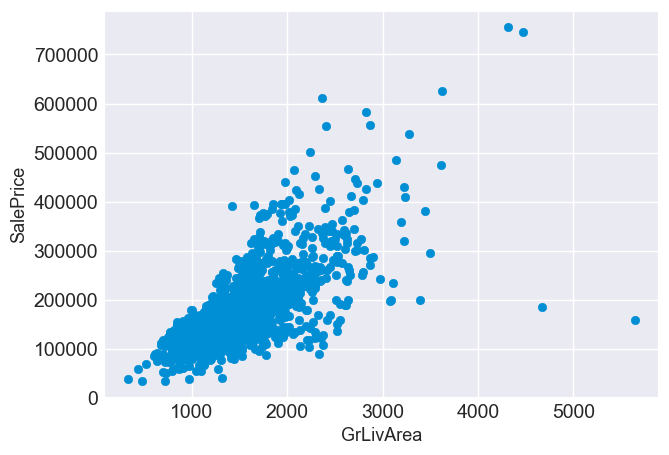

In [393]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

large area but still small SalePrice

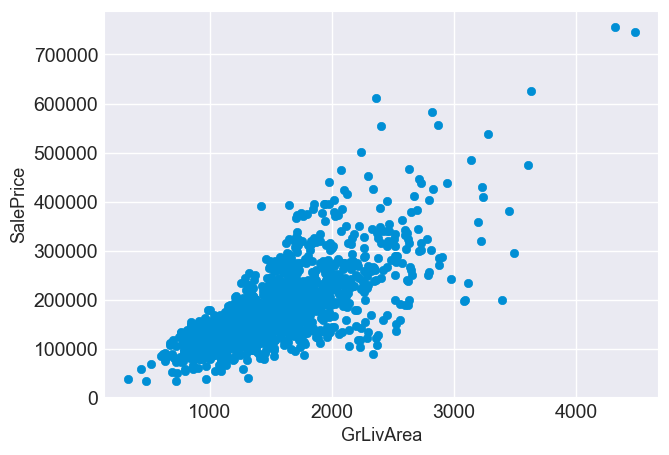

In [394]:
#Deleting outliers

train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

# Log-Transformation of target variable

We preivously saw that SalePrice was heavily skewed, we would need to transform this variable


mu = 180932.92 and sigma = 79467.79


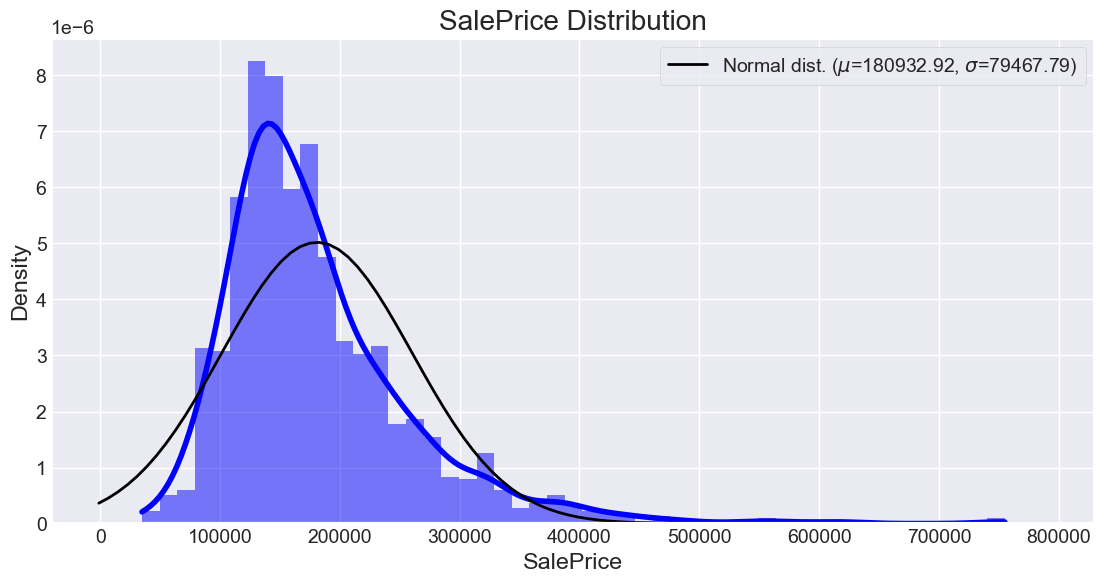

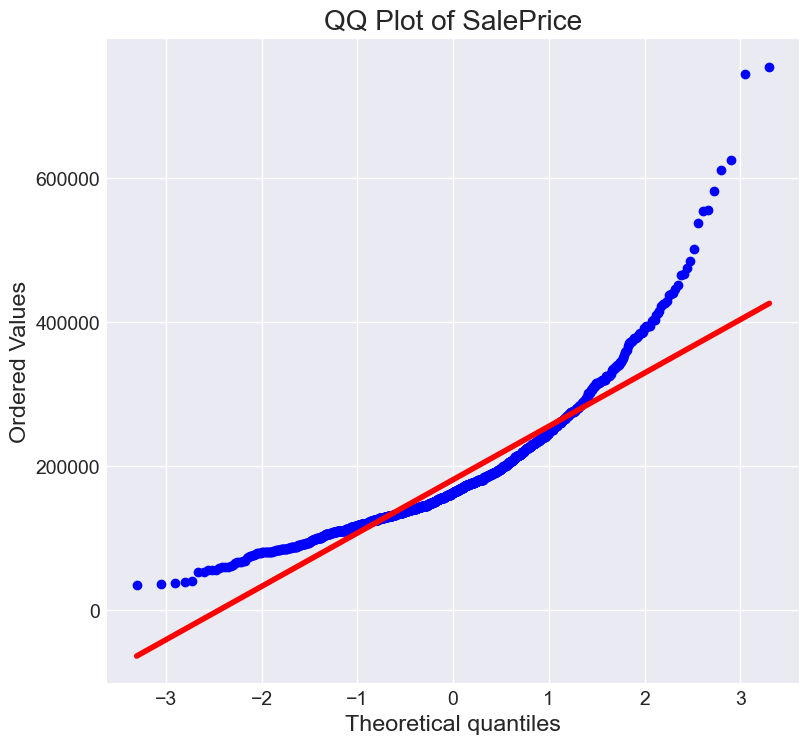

In [395]:

# Fit a normal distribution to the data
(mu, sigma) = stats.norm.fit(train['SalePrice'])
print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

# Plot the histogram and the fitted normal distribution
plt.figure(figsize=(12, 6))

# Histogram with KDE and fitted normal distribution
sns.histplot(train['SalePrice'], kde=True, stat='density', linewidth=0, color='blue')

# Plot the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2, label=f'Normal dist. ($\\mu$={mu:.2f}, $\\sigma$={sigma:.2f})')

plt.legend(loc='best')
plt.ylabel('Density')
plt.title('SalePrice Distribution')

# Show the plot
plt.show()

# QQ-plot
plt.figure(figsize=(8, 8))
stats.probplot(train['SalePrice'], dist="norm", plot=plt)
plt.title('QQ Plot of SalePrice')
plt.show()


log transforming the feature to remove skewness

mu = 12.02 and sigma = 0.40


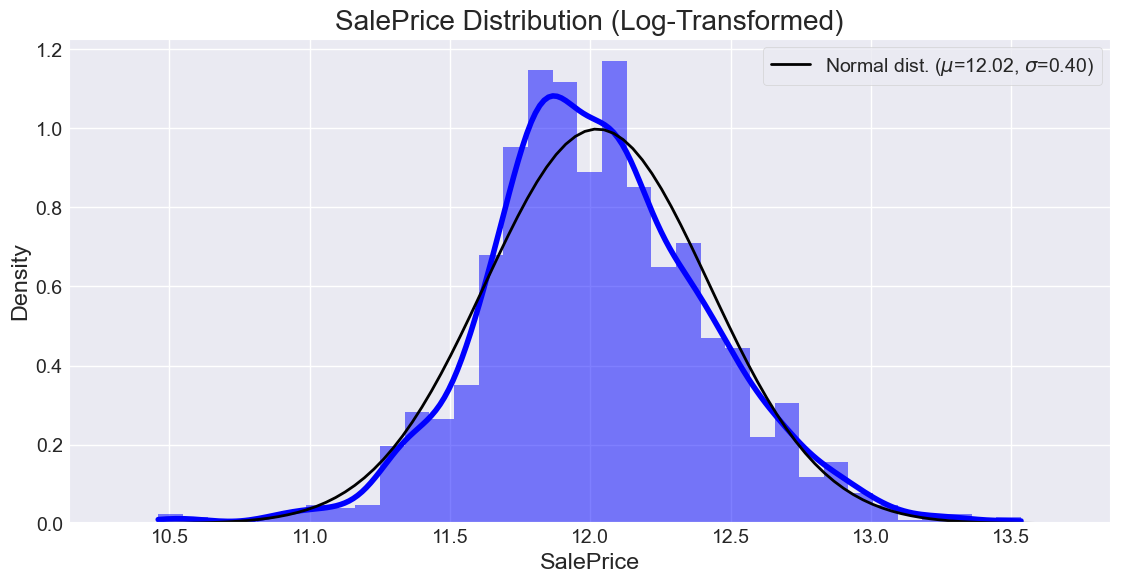

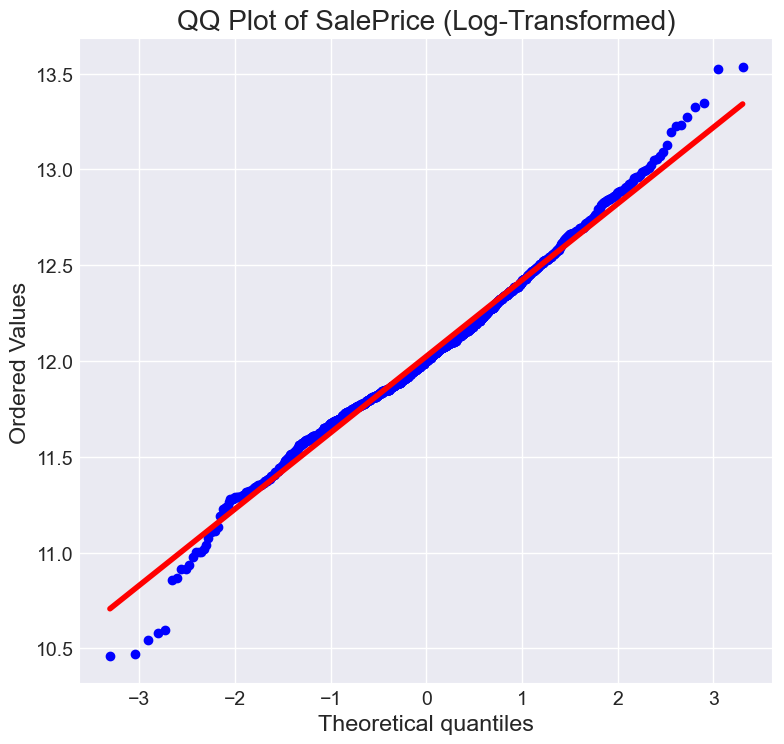

In [396]:

# Apply log transformation
train["SalePrice"] = np.log1p(train["SalePrice"])

# Fit a normal distribution to the transformed data
(mu, sigma) = stats.norm.fit(train['SalePrice'])
print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

# Plot histogram and fitted normal distribution
plt.figure(figsize=(12, 6))

# Plot the histogram with KDE and fitted normal distribution
sns.histplot(train['SalePrice'], kde=True, stat='density', linewidth=0, color='blue')

# Plot the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2, label=f'Normal dist. ($\\mu$={mu:.2f}, $\\sigma$={sigma:.2f})')

plt.legend(loc='best')
plt.ylabel('Density')
plt.title('SalePrice Distribution (Log-Transformed)')

# Show the plot
plt.show()

# QQ-plot
plt.figure(figsize=(8, 8))
stats.probplot(train['SalePrice'], dist="norm", plot=plt)
plt.title('QQ Plot of SalePrice (Log-Transformed)')
plt.show()


Concatenate the train and test data in the same dataframe.

In [397]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print(f"all_data size is : {all_data.shape}")

all_data size is : (2917, 79)


# Treating missing values

In [398]:
features_with_na = {feature: all_data[feature].isnull().sum() for feature in all_data.columns 
                    if all_data[feature].isnull().sum() > 0}

size = all_data.shape[0]
a = pd.DataFrame({
    'features': list(features_with_na.keys()),
    'Total': list(features_with_na.values()),
    'Missing_PCT': [np.round((features_with_na[i] / size) * 100, 3) for i in features_with_na.keys()]
}).sort_values(by='Missing_PCT', ascending=False).reset_index(drop=True)
a.style.background_gradient(cmap='Reds') 

,features,Total,Missing_PCT
0,PoolQC,2908,99.691000
1,MiscFeature,2812,96.400000
2,Alley,2719,93.212000
3,Fence,2346,80.425000
4,MasVnrType,1766,60.542000
5,FireplaceQu,1420,48.680000
6,LotFrontage,486,16.661000
7,GarageQual,159,5.451000
8,GarageYrBlt,159,5.451000
9,GarageCond,159,5.451000


In [399]:
print(f"Total number of missing values: {all_data.isna().sum().sum()}")

Total number of missing values: 15700


## Numerical features

In [400]:
num_with_nan = [feature for feature in features_with_na.keys() if train[feature].dtypes != 'O']
pd.DataFrame({
    'feature': num_with_nan,
    'Count': [all_data[i].isna().sum() for i in num_with_nan]
})

,feature,Count
0,LotFrontage,486
1,MasVnrArea,23
2,BsmtFinSF1,1
3,BsmtFinSF2,1
4,BsmtUnfSF,1
5,TotalBsmtSF,1
6,BsmtFullBath,2
7,BsmtHalfBath,2
8,GarageYrBlt,159
9,GarageCars,1


**Appropriate missing values for numerical variables**
* `LotFrontage`: groupby `Neighborhood` and fill the **median** value for that neighborhood.
* `MasVnrArea` - **median** or **0** as missing value suggests a no mason veneer present
*  `BsmtFinSF1`, `BsmtFinSF2`, `BsmtUnfSF`, `TotalBsmtSF`, `BsmtFullBath`, `BsmtHalfBath` - No basement present - **0**
* `GarageYrBlt`, `GarageCars`, `GarageArea` - no garage present - **0**

For **BsmX** variables we can drop all variables except `TotalBsmtSF`.

For **GarageX** variable we can only keep `GarageCars` as it will also give us information about the `area`.




The mean and median values of these features are different so it will be better if we fill these values with **median.**

What we can also do is create a new feature with binary values to indicate if the value was missing at that point

In [401]:

median_lotfrontage = all_data.groupby('Neighborhood')['LotFrontage'].median()

# Map the median values back to the original DataFrame
all_data['LotFrontage'] = all_data.apply(
    lambda row: median_lotfrontage[row['Neighborhood']] if pd.isna(row['LotFrontage']) else row['LotFrontage'],
    axis=1
)

# Verify that there are no missing values left
missing_values = all_data['LotFrontage'].isna().sum()
print(f'Number of missing values in "LotFrontage": {missing_values}')


Number of missing values in "LotFrontage": 0


In [402]:
# MasVnrArea

all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data["MasVnrArea"].isna().sum()

np.int64(0)

In [403]:
# BsmtX

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
            'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

all_data[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
         'BsmtFullBath', 'BsmtHalfBath']].isna().sum()

BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
BsmtFullBath    0
BsmtHalfBath    0
dtype: int64

In [404]:
# GarageX

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

all_data[['GarageYrBlt', 'GarageArea', 'GarageCars']].isna().sum()

GarageYrBlt    0
GarageArea     0
GarageCars     0
dtype: int64

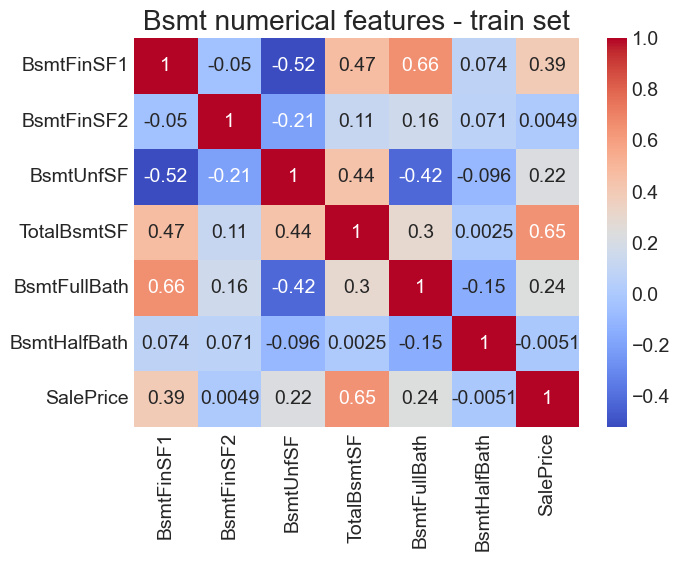

In [405]:
sns.heatmap(pd.DataFrame(
    {
        'BsmtFinSF1': train['BsmtFinSF1'],
        'BsmtFinSF2': train['BsmtFinSF2'], 
        'BsmtUnfSF': train['BsmtUnfSF'],
        'TotalBsmtSF': train['TotalBsmtSF'], 
        'BsmtFullBath': train['BsmtFullBath'], 
        'BsmtHalfBath': train['BsmtHalfBath'],
        'SalePrice': train['SalePrice'],
    }
).corr(), cmap='coolwarm', annot=True) 
plt.title("Bsmt numerical features - train set")
plt.show()

As suspected, `TotalBsmtSF` seems the only good choice to keep, also `BsmtFinSF1` can be kept if required. We can perform a feature selection on the features remaining at the end, to filter some more

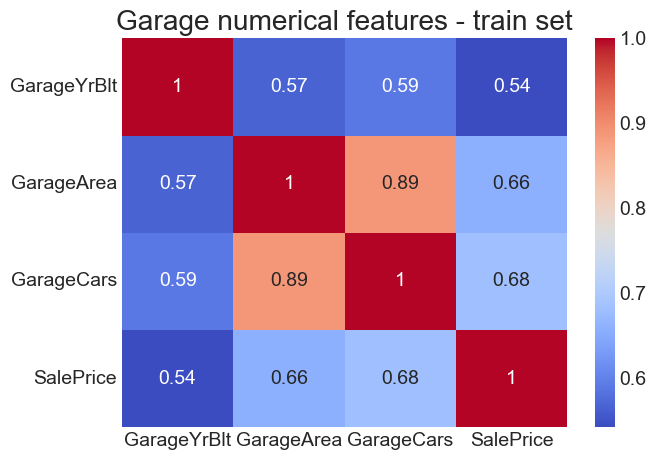

In [406]:
sns.heatmap(pd.DataFrame(
    {
        'GarageYrBlt': train['GarageYrBlt'], 
        'GarageArea': train['GarageArea'],
        'GarageCars': train['GarageCars'],
        'SalePrice': train['SalePrice'],
    }).corr(), annot=True, cmap='coolwarm'
)
plt.title("Garage numerical features - train set")
plt.show()

As suspected, `GarageCars` is highly correlated with `GarageArea` and also has the highest correlation with `SalePrice`

Candidate features to be dropped:
* `BsmtFinSF2`
* `BsmtUnfSF`
* `BsmtFullBath`
* `BsmtHalfBath`
* `GarageYrBuilt`
* `GarageArea`

In [407]:
to_remove_ = ['BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath', 
             'GarageYrBlt', 'GarageArea']

In [408]:
all_data[num_with_nan].isna().sum()

LotFrontage     0
MasVnrArea      0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
BsmtFullBath    0
BsmtHalfBath    0
GarageYrBlt     0
GarageCars      0
GarageArea      0
dtype: int64

## Categorical features

In [409]:
cat_nan = [feature for feature in features_with_na if all_data[feature].dtypes == "O"]
pd.DataFrame({
    'feature': cat_nan,
    'Count': [all_data[i].isna().sum() for i in cat_nan]
}).sort_values(by="Count", ascending = False).reset_index(drop=True)

,feature,Count
0,PoolQC,2908
1,MiscFeature,2812
2,Alley,2719
3,Fence,2346
4,MasVnrType,1766
5,FireplaceQu,1420
6,GarageFinish,159
7,GarageCond,159
8,GarageQual,159
9,GarageType,157


**Appropriate missing values for numerical variables**
* `FireplaceQu`: missing values indicates _No fireplace present_ - **None.**
* `GarageType`, `GarageFinish`, `GarageQual` & `GarageCond`: missing value indicates there's _no garage_ - **None.**
* `BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1` & `BsmtFinType2`: missing values indicate there's _no basement_ - **None.**
* `MasVnrType`: missing value indicates there' _no masonry veneer_ - **None.**
* `MSZoning`: missing value can be filled by the most frequent value _RL_ - **mode.**
* `Functional`: from description _NA_ indicates - **Typical.**
* `Utilities`: feature can be **dropped** is heavily dominated by _AllPub_. I was wrong in determining it to be important in the EDA part.
* `Electrical`: 1 missing value, fill with most frequent value - **mode.**
* `KitchenQual`: 1 missing value, fill with most frequent value - **mode.**
* `Exterior1st` & `Exterior2nd`: 1 missing values in both, fill with most frequent value - **mode.**
* `SaleType`: 1 missing value, fill with most frequent value - **mode.**


Although, I can cannot provide the proof of it but `BsmtX` and  `GarageX` variables are mostly likely heavily correlated with each other, we can keep their numerical counterparts that convey the same information.

We can either drop these variables or keep them to see the result during feature selection.
 
In the future version, I'll update the notebook with methods to find the categorical coefficient between these variables and with the output to test my hypothesis above.

* We will drop features `PoolQC`, `MiscFeature`, `Alley` and `Fence`, `Utilities`.



In [410]:
to_remove_.extend(['PoolQC','MiscFeature','Alley','Fence', 'Utilities'])

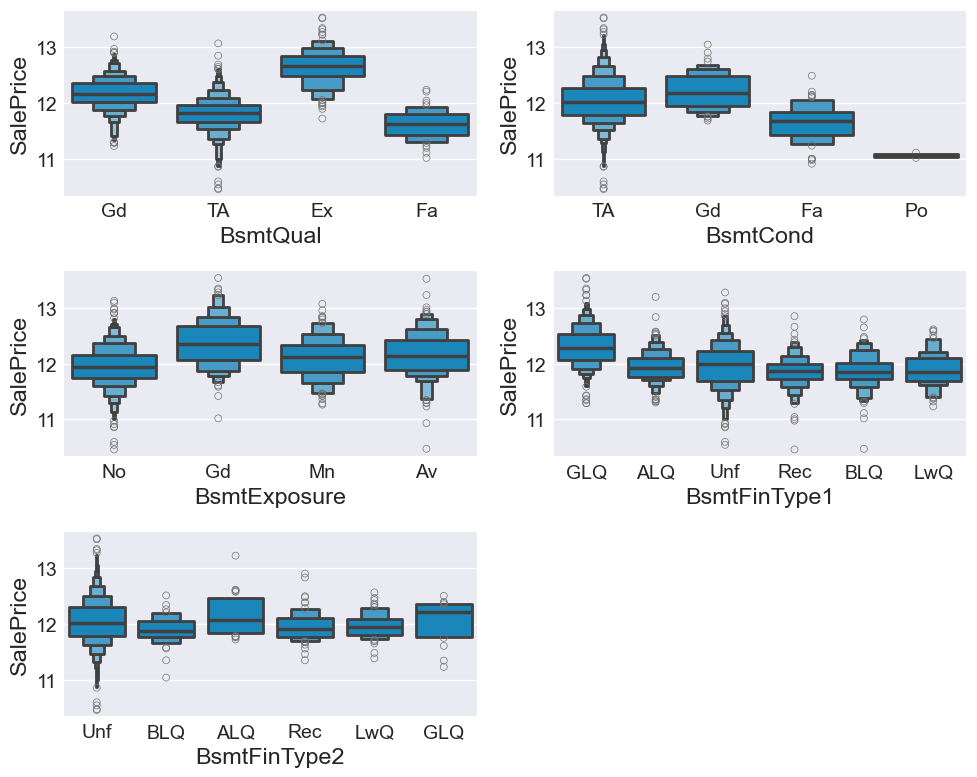

In [411]:
plt.figure(figsize=(10, 8))
basement_variables = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 
                      'BsmtFinType1', 'BsmtFinType2']

for i, feature in enumerate(basement_variables, 1):
    plt.subplot(3, 2, i)
    sns.boxenplot(data=train, x=feature, y=train['SalePrice'])

plt.tight_layout(h_pad=1.2)
plt.show()

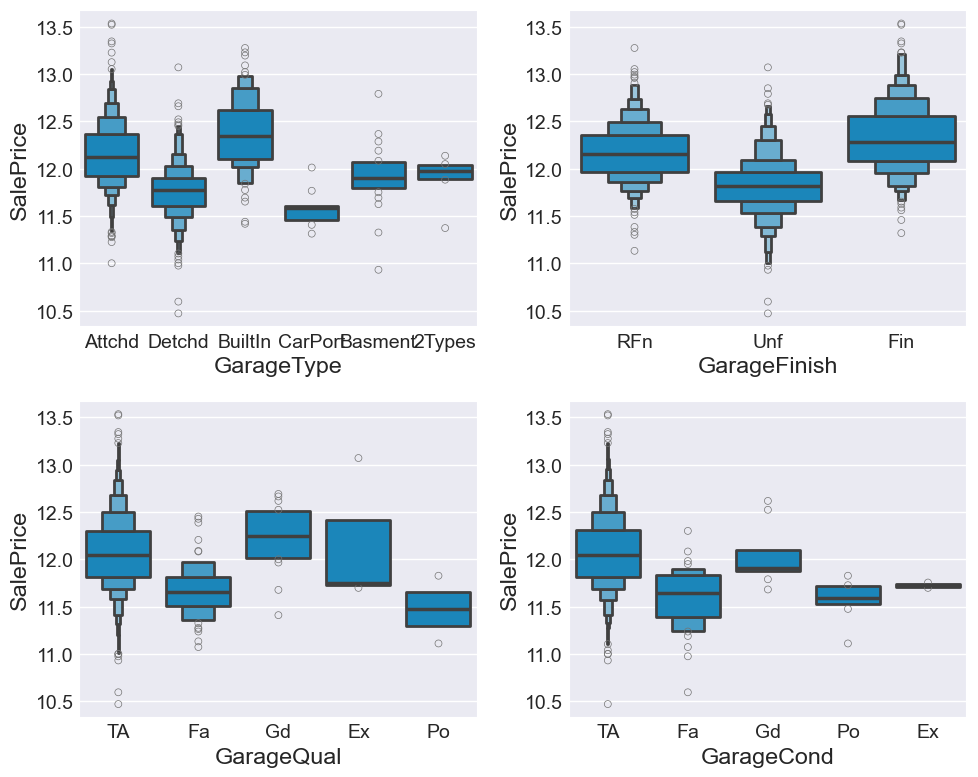

In [412]:
plt.figure(figsize=(10, 8))
garage_variables = ['GarageType', 'GarageFinish', 'GarageQual', 
                    'GarageCond']

for i, feature in enumerate(garage_variables, 1):
    plt.subplot(2, 2, i)
    sns.boxenplot(data=train, x=feature, y=train['SalePrice'])

plt.tight_layout(h_pad=1.2)
plt.show()

In [413]:
# List of features to fill with 'None'
fill_none = ["FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", 
             "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "MasVnrType"]

# Iterate through each feature and fill NaNs with 'None'
for feature in fill_none:
    all_data[feature] = all_data[feature].fillna("None")

# Check if there are any missing values left in these features
missing_values_count = all_data[fill_none].isna().sum().sum()
print(f'Total missing values in specified features: {missing_values_count}')


Total missing values in specified features: 0


In [414]:
# List of features to fill with mode
fill_mode = ["MSZoning", "Electrical", "KitchenQual", "Exterior1st", 
             "Exterior2nd", "SaleType"]

# Fill missing values with the mode for each feature
for feature in fill_mode:
    mode_value = all_data[feature].mode()[0]
    all_data[feature] = all_data[feature].fillna(mode_value)

# Check if there are any missing values left in these features
missing_values_count = all_data[fill_mode].isna().sum().sum()
print(f'Total missing values in specified features: {missing_values_count}')


Total missing values in specified features: 0


In [415]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [416]:
print(f"Number of missing values: {all_data.isna().sum().sum()}")

Number of missing values: 10787


_____________________________

In [417]:
# dropping features

all_data.drop(to_remove_, axis=1, inplace=True)
all_data.shape

(2917, 68)

What we can do is keep two seperate dataframe 
1. Consisting of categorical `GarageX` and `BsmtX` variables.
2. One Without.

In [418]:
all_data_cat = all_data.copy()
all_data_cat.shape

(2917, 68)

In [419]:
all_data_free = all_data.copy()
remove_cat_garage_bsmt = ["GarageType", "GarageFinish", "GarageQual", "GarageCond", 
             "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]
all_data_free.drop(remove_cat_garage_bsmt, axis=1, inplace=True)
all_data_free.shape

(2917, 59)

# Date and Time Engineering


What we could do is express the 3 year variables in term of time intervals by subracting their value from `YrSold` as done during EDA.
We can then replace the 3 variable with the one that shows the highest correlation with the `SalePrice`.

# Variable Transformation

## Transforming some numerical variables that are really categorical

In [420]:
# MSSubClass=The building class
all_data_cat['MSSubClass'] = all_data_cat['MSSubClass'].apply(str)


# Changing OverallCond into a categorical variable
all_data_cat['OverallCond'] = all_data_cat['OverallCond'].astype(str)


# Year and month sold are transformed into categorical features.
all_data_cat['YrSold'] = all_data_cat['YrSold'].astype(str)
all_data_cat['MoSold'] = all_data_cat['MoSold'].astype(str)

# same transformation to other dataframe
# MSSubClass=The building class
all_data_free['MSSubClass'] = all_data_free['MSSubClass'].apply(str)


# Changing OverallCond into a categorical variable
all_data_free['OverallCond'] = all_data_free['OverallCond'].astype(str)


# Year and month sold are transformed into categorical features.
all_data_free['YrSold'] = all_data_free['YrSold'].astype(str)
all_data_free['MoSold'] = all_data_free['MoSold'].astype(str)

## Label Encoding some categorical features

In [421]:
from sklearn.preprocessing import LabelEncoder


cols = ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 
        'CentralAir', 'ExterCond', 'ExterQual', 'FireplaceQu', 'Functional', 
        'GarageCond', 'GarageFinish', 'GarageQual', 'HeatingQC', 'KitchenQual', 
        'LandSlope', 'LotShape', 'MSSubClass', 'MoSold', 'OverallCond', 'PavedDrive', 
         'Street', 'YrSold']

for feature in cols:
    encoder = LabelEncoder()
    encoder.fit(all_data_cat[feature].values)
    all_data_cat[feature] = encoder.transform(all_data_cat[feature].values)


print(f'Shape all_data_cat: {all_data_cat.shape}')

# Same for all_data_free

cols = ['CentralAir', 'ExterCond', 'ExterQual', 'FireplaceQu', 'Functional', 
        'HeatingQC', 'KitchenQual', 'LandSlope', 'LotShape', 'MSSubClass', 
        'MoSold', 'OverallCond', 'PavedDrive', 'Street', 'YrSold']

for feature in cols:
    encoder = LabelEncoder()
    encoder.fit(all_data_free[feature].values)
    all_data_free[feature] = encoder.transform(all_data_free[feature].values)



print(f'Shape all_data_free: {all_data_free.shape}')

Shape all_data_cat: (2917, 68)
Shape all_data_free: (2917, 59)


According to various top kernels total square footage might be an importatnt feature. Giving it a moments thought we can see why.

In [422]:
all_data_cat['TotalSF'] = all_data_cat['TotalBsmtSF'] + all_data_cat['1stFlrSF'] + all_data_cat['2ndFlrSF']

all_data_free['TotalSF'] = all_data_free['TotalBsmtSF'] + all_data_free['1stFlrSF'] + all_data_free['2ndFlrSF']

## Skewed feature transformation

During EDA we saw many continuous numeric features that were skewed. In this section we'll apply a Box-Cox transformation on them.

In [423]:
# all_data_cat

numeric_feature_cat = all_data_cat.select_dtypes("number").columns

# Check the skew of all numerical features
skewed_feats_cat = all_data_cat[numeric_feature_cat].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness_cat = pd.DataFrame({'Skew' :skewed_feats_cat})
skewness_cat.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
EnclosedPorch,4.002344
ScreenPorch,3.945101
MasVnrArea,2.621719


In [424]:
# all_data_free

numeric_feature_free = all_data_free.select_dtypes("number").columns

# Check the skew of all numerical features
skewed_feats_free = all_data_free[numeric_feature_free].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness_free = pd.DataFrame({'Skew' :skewed_feats_free})
skewness_free.head(10)



Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
EnclosedPorch,4.002344
ScreenPorch,3.945101
MasVnrArea,2.621719


**Box Cox Transformation of (highly) skewed features**

We use the scipy function **boxcox1p** which computes the Box-Cox transformation of  $1+x$ .

Note that setting  $λ=0$  is equivalent to $log1p$ used above for the target variable.

See [this](http://onlinestatbook.com/2/transformations/box-cox.html) page for more details on Box Cox Transformation as well as [the scipy function's page](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.boxcox1p.html)



In [425]:
# for all_data_cat

from scipy.special import boxcox1p

skewness_cat = skewness_cat[abs(skewness_cat) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness_cat.shape[0]))

skewed_features_cat = skewness_cat.index
lam = 0.15
for feat in skewed_features_cat:
    all_data_cat[feat] = boxcox1p(all_data_cat[feat], lam)

There are 50 skewed numerical features to Box Cox transform


In [426]:
# Compute skewness for numerical features
numerical_features = all_data.select_dtypes(include=[np.number])
skewness = numerical_features.apply(lambda x: skew(x.dropna()))
skewness_free = skewness[abs(skewness) > 0.75]

print("There are {} skewed numerical features to Box Cox transform".format(skewness_free.shape[0]))

skewed_features_free = skewness_free.index
lam = 0.15
for feat in skewed_features_free:
    #all_data[feat] += 1
    all_data_free[feat] = boxcox1p(all_data_free[feat], lam)
 

There are 17 skewed numerical features to Box Cox transform


In [427]:
print(f"all_data_cat.shape: {all_data_cat.shape}")
print(f"all_data_free.shape: {all_data_free.shape}")

all_data_cat.shape: (2917, 69)
all_data_free.shape: (2917, 60)


In [428]:
all_data_free.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtFinSF1,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageCars,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF
0,2.885846,RL,5.831328,19.212182,1,3,Lvl,Inside,0,CollgCr,Norm,Norm,1Fam,2Story,7,4,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,8.059126,2,4,PConc,11.170327,856.0,GasA,0,1,SBrkr,11.692623,11.686189,0.0,13.698888,2,1,3,0.730463,2,8,6,0,3,2.0,2,0.000000,5.714669,0.000000,0.0,0.0,0.0,0.0,4,2,WD,Normal,2566.0
1,2.055642,RL,6.221214,19.712205,1,3,Lvl,FR2,0,Veenker,Feedr,Norm,1Fam,1Story,6,7,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,3,4,CBlock,12.062832,1262.0,GasA,0,1,SBrkr,12.792276,0.000000,0.0,12.792276,2,0,3,0.730463,3,6,6,1,5,2.0,2,9.010206,0.000000,0.000000,0.0,0.0,0.0,0.0,7,1,WD,Normal,2524.0
2,2.885846,RL,5.914940,20.347241,1,0,Lvl,Inside,0,CollgCr,Norm,Norm,1Fam,2Story,7,4,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,7.646538,2,4,PConc,10.200343,920.0,GasA,0,1,SBrkr,11.892039,11.724598,0.0,13.832085,2,1,3,0.730463,2,6,6,1,5,2.0,2,0.000000,5.053371,0.000000,0.0,0.0,0.0,0.0,11,2,WD,Normal,2706.0
3,3.011340,RL,5.684507,19.691553,1,0,Lvl,Corner,0,Crawfor,Norm,Norm,1Fam,2Story,7,4,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,3,4,BrkTil,8.274266,756.0,GasA,2,1,SBrkr,12.013683,11.354094,0.0,13.711364,1,0,3,0.730463,2,7,6,1,2,3.0,2,0.000000,4.745132,8.797736,0.0,0.0,0.0,0.0,4,0,WD,Abnorml,2473.0
4,2.885846,RL,6.314735,21.325160,1,0,Lvl,FR2,0,NoRidge,Norm,Norm,1Fam,2Story,8,4,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,9.391827,2,4,PConc,10.971129,1145.0,GasA,0,1,SBrkr,12.510588,12.271365,0.0,14.480029,2,1,4,0.730463,2,9,6,1,5,3.0,2,8.013884,6.314735,0.000000,0.0,0.0,0.0,0.0,3,2,WD,Normal,3343.0


In [429]:
# apply min max scaler first

In [430]:
all_data_cat = pd.get_dummies(all_data_cat)
print(all_data_cat.shape)

(2917, 206)


In [431]:
all_data_free = pd.get_dummies(all_data_free)
print(all_data_free.shape)

(2917, 191)


In [432]:
numeric_feature_free = all_data_free.select_dtypes(include=[np.number]).columns

In [433]:
train_cat = all_data_cat[:ntrain]
test_cat = all_data_cat[ntrain:]

In [434]:
train_free = all_data_free[:ntrain]
test_free = all_data_free[ntrain:]

In [435]:
train_cat.shape, test_cat.shape

((1458, 206), (1459, 206))

In [436]:
train_free.shape, test_free.shape

((1458, 191), (1459, 191))

In [437]:
# Using MinMaxScaler

In [438]:
X_cat = train_cat.copy()
cols_cat = X_cat.columns

scaler_cat = MinMaxScaler()

# fitting MinaMaxScaler to training data
scaler_cat.fit(X_cat)

# transforming training and test data
X_cat = scaler_cat.transform(X_cat)
test_cat = scaler_cat.transform(test_cat)


X_cat = pd.DataFrame(X_cat, columns=[cols_cat])
test_cat = pd.DataFrame(test_cat, columns=[cols_cat])
X_cat.shape, test_cat.shape

((1458, 206), (1459, 206))

In [439]:
X_free = train_free.copy()
cols_free = X_free.columns

scaler_free = MinMaxScaler()

# fitting MinaMaxScaler to training data
scaler_free.fit(X_free)

# transforming training and test data
X_free = scaler_free.transform(X_free)
test_free = scaler_free.transform(test_free)


X_free = pd.DataFrame(X_free, columns=[cols_free])
test_free = pd.DataFrame(test_free, columns=[cols_free])
X_free.shape, test_free.shape

((1458, 191), (1459, 191))

In [440]:
y = y_train

# Feature Selection

## using Lasso

In [441]:
# Using SelectFromModel with lasso for selecting best features

In [442]:
# for X_cat
lasso = Pipeline([
    ("scaler", RobustScaler()), 
    ("ls", Lasso(alpha =0.0005, random_state=1))
])

feature_sel_model = SelectFromModel(lasso).fit(X_cat, y)

coefficiets = feature_sel_model.estimator_['ls'].coef_
X_cat_cols = []

for i, j in enumerate(coefficiets):
    if j != 0:
        X_cat_cols.append(X_cat.columns[i])


# selected_feat_cat = X_cat.columns[(feature_sel_model.get_support())]
print(len(X_cat_cols))

X_cat_lasso = X_cat[X_cat_cols].reset_index(drop=True)
test_cat_lasso = test_cat[X_cat_cols].reset_index(drop=True)

print(X_cat_lasso.shape, test_cat_lasso.shape)

83
(1458, 83) (1459, 83)


We came down from 206 features to 83

In [443]:
# for X_free
lasso = Pipeline([
    ("scaler", RobustScaler()), 
    ("ls", Lasso(alpha =0.0005, random_state=1))
])

feature_sel_model = SelectFromModel(lasso).fit(X_free, y)

coefficiets = feature_sel_model.estimator_['ls'].coef_
X_free_cols = []

for i, j in enumerate(coefficiets):
    if j != 0:
        X_free_cols.append(X_free.columns[i])


print(len(X_free_cols))

X_free_lasso = X_free[X_free_cols].reset_index(drop=True)
test_free_lasso = test_free[X_free_cols].reset_index(drop=True)

print(X_free_lasso.shape, test_free_lasso.shape)

77
(1458, 77) (1459, 77)


We came down from 191 features to 77

## Using tree based models



In [444]:
tree_models = {
    "Light_GBM": LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=1200,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf=6, min_sum_hessian_in_leaf = 11),
    
    "XGBoost": XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, 
                 max_depth=5, min_child_weight=1.7817, n_estimators=2200,
                 reg_alpha=0.4640, reg_lambda=0.8571, subsample=0.5213,
                 nthread = -1, objective="reg:squarederror", random_state=42), 
    
    "Gradient_boosting": GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, 
                                                   max_depth=6, min_samples_split=17, 
                                                   max_features='sqrt', min_samples_leaf=13, 
                                                   loss='huber', random_state=42),
               
    "Extra_trees": ExtraTreesRegressor(n_estimators=2000, max_depth=9, min_samples_split= 13, 
                        max_leaf_nodes=11, min_weight_fraction_leaf=0.39, max_features='sqrt', 
                        n_jobs=-1, random_state=42),
}

Demo: feature selection using **extra trees**

In [445]:
if isinstance(y_train, np.ndarray):
    y_train = pd.Series(y_train)
# Check shapes
print(f"X_cat shape: {X_cat.shape}")
print(f"y_train shape: {y_train.shape}")

# Align data
X_cat, y_train = X_cat.align(y_train, join='inner', axis=0)

# Verify shapes after alignment
print(f"Aligned X_cat shape: {X_cat.shape}")
print(f"Aligned y_train shape: {y_train.shape}")

# Perform the feature selection again
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesRegressor

tree_models = {
    "Extra_trees": ExtraTreesRegressor(n_estimators=2000, max_depth=9, min_samples_split=13, 
                                        max_leaf_nodes=11, min_weight_fraction_leaf=0.39, max_features='sqrt', 
                                        n_jobs=-1, random_state=42)
}

selection_extra_cat = SelectFromModel(tree_models["Extra_trees"]).fit(X_cat, y_train)
selected_feat_extra_cat = X_cat.columns[selection_extra_cat.get_support()]
print("Number of selected features:", len(selected_feat_extra_cat))

X_cat_extra = X_cat[selected_feat_extra_cat].reset_index(drop=True)
test_cat_extra = test_cat[selected_feat_extra_cat].reset_index(drop=True)
print("Transformed shape: ", X_cat_extra.shape, test_cat_extra.shape)


X_cat shape: (1458, 206)
y_train shape: (1458,)
Aligned X_cat shape: (1458, 206)
Aligned y_train shape: (1458,)
Number of selected features: 25
Transformed shape:  (1458, 25) (1459, 25)


# Model Building

We'll run a 7-Fold cross validation of **X_cat** and **X_free** to determine which if _BsmtX_ and _GarageX_ variables removed have any effect on the prediction. 

Also we'll 

We'll train our data on 4 Boosting trees algorithms:
1. XGBoost
2. Gradient Boosting trees
3. Light GBM
4. Extra trees


* We can built a Pipeline of _RobustScaler_ , _tree_based_ selection and _Final model_ to see how they work.
* If time permits I'll add this in future versions.
* For now we'll directly use a tree based models to fit and predict with cross-validation.


In [446]:
def fit_model(model_name, model, X, y, n_folds=7, show=10):
    X = X.copy()
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    output = cross_validate(model, X.values, y, scoring="neg_mean_squared_error", cv=kf, return_estimator=True)
    
    feat_scores = pd.DataFrame(index=X.columns)

    for idx,estimator in enumerate(output['estimator']):
        temp = pd.Series(estimator.feature_importances_, index=X.columns)
        feat_scores[str(idx)] = temp

    feat_scores.reset_index(inplace=True)

    feat_scores['Importance'] = feat_scores.mean(axis=1)

    feat_scores = feat_scores.sort_values(by="Importance", ascending=False)[['level_0', "Importance"]].head(show)

    plt.figure(figsize=(15, 10))
    plt.gca()
    sns.barplot(x=feat_scores['Importance'], y=feat_scores['level_0'])
    plt.ylabel("Features")
    plt.title(f"Feature Importance: {model_name}")

    print(f"{model_name} score => RMSE: {np.round(np.mean(np.sqrt(-output['test_score'])), 4)}, std: {np.round(np.std(-output['test_score']), 4)}")
    
    plt.show()
    print("-------------------------------------------------------------------------------------------------")

Running the next cell will for each **X_set** created perform a cross validation run using all tree based model, plot best 30 features that are most important.

In [447]:
print("Running boosting tree on X_cat_lasso, X_cat_free, X_cat, X_free")

training_data = {
    "X_cat_lasso": X_cat_lasso, "X_free_lasso": X_free_lasso,
    "X_cat": X_cat, "X_free": X_free, 
}


for X_name, X in training_data.items():
    print(f"X => {X_name}, shape: {X.shape}\n")
    for model_name, model in tree_models.items():
        fit_model(model_name, model, X, y, n_folds=7, show=35)
    print()

Running boosting tree on X_cat_lasso, X_cat_free, X_cat, X_free
X => X_cat_lasso, shape: (1458, 83)



TypeError: can only concatenate str (not "float") to str

# Stacking regressor

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.base import clone

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

level0 = list()
# level0.extend(('LGB', tree_models["Light_GBM"]))
level0.append(('xgb', tree_models["XGBoost"]))
level0.append(('GBT', tree_models["Gradient_boosting"]))
level0.append(('xtra', tree_models["Extra_trees"]))

training_data = {"X_cat_lasso": X_cat_lasso, "X_free_lasso": X_free_lasso,
                 "X_cat": X_cat, "X_free": X_free, 
                 }


level1_models = {
    "Linear": LinearRegression(), 
#     "Linear_SVR":  LinearSVR(epsilon=1.5),
#     "MLP": MLPRegressor(hidden_layer_sizes=(2), activation='logistic', solver='sgd', 
#                         max_iter=1000, learning_rate='adaptive', random_state=42)
}

**Private Run**


1. X => X_cat_lasso, shape: (1458, 83)
    * Model: Linear, R2: 0.9851682263983834, RMSE: 0.04847376103391416
    * Model: Linear_SVR, R2: -6.633282458849109, RMSE: 0.7302971301321612
    * Model: MLP, R2: -2983940.9730241755, RMSE: 0.39935765079237545
    

2. X => X_free_lasso, shape: (1458, 77)
    * Model: Linear, R2: 0.981016025855836, RMSE: 0.05452379484010679
    * Model: Linear_SVR, R2: -6.461431642367199, RMSE: 0.7167880791589558
    * Model: MLP, R2: -2982300.610854054, RMSE: 0.39935750649014945


3. X => X_cat, shape: (1458, 206)
    * Model: Linear, R2: 0.9818263620627218, RMSE: 0.053600087870622565
    * Model: Linear_SVR, R2: -6.812972415367375, RMSE: 0.7336647698772716
    * Model: MLP, R2: -2964776.4375035004, RMSE: 0.3993568326589984


4. X => X_free, shape: (1458, 191)
    * Model: Linear, R2: 0.9825960824103169, RMSE: 0.05235665694025279
    * Model: Linear_SVR, R2: -6.6057353381424395, RMSE: 0.7214971271278083
    * Model: MLP, R2: -2920872.063956515, RMSE: 0.3993558505344274

# Final Run and Creating Submission

In [ ]:
model_ = StackingRegressor(estimators=level0, final_estimator=level1_models['Linear'], cv=7, n_jobs=-1)
model_.fit(X_cat_lasso, y)
y_preds = model_.predict(X_cat_lasso)
print(f"Model: Linear, R2: {r2_score(y_preds, y)}, RMSE: {rmsle(y_preds, y)}")

In [ ]:
y_preds = model_.predict(test_cat_lasso)
# print(y_preds.shape, test_id.shape)
my_submission = pd.DataFrame({'Id': test_id, 'SalePrice': y_preds})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)